In [1]:
# Imports
import os
import pandas as pd
import numpy as np

# Matplotlib / Seaborn are optional for headless runs; try to import and fall back gracefully
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    PLOTTING_AVAILABLE = True
except Exception as e:
    plt = None
    sns = None
    PLOTTING_AVAILABLE = False

import joblib
from pathlib import Path

if PLOTTING_AVAILABLE:
    sns.set(style="whitegrid")
else:
    # provide a minimal placeholder to avoid NameError in the notebook if plotting is skipped
    class _Dummy:
        def __getattr__(self, name):
            def _noop(*args, **kwargs):
                return None
            return _noop
    sns = _Dummy()
    plt = None


In [2]:
# Load dataset (try local, else attempt to use kagglehub)
csv_path = Path('used_cars.csv')
if not csv_path.exists():
    try:
        import kagglehub
        dataset_dir = kagglehub.dataset_download('taeefnajib/used-car-price-prediction-dataset')
        candidate = Path(dataset_dir) / 'used_cars.csv'
        if candidate.exists():
            csv_path = candidate
    except Exception:
        pass

df = pd.read_csv(csv_path)
print('Loaded', csv_path)
df.shape

D:\tg download\ML assignment\.venv-1\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded C:\Users\12yem\.cache\kagglehub\datasets\taeefnajib\used-car-price-prediction-dataset\versions\1\used_cars.csv


(4009, 12)

In [3]:
# Quick EDA: head, info, describe
display(df.head())
display(df.info())
display(df.describe(include='all').T)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Ford,Utility Police Interceptor Base,2013,"51,000 mi.",E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,"$10,300"
1,Hyundai,Palisade SEL,2021,"34,742 mi.",Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,"$38,005"
2,Lexus,RX 350 RX 350,2022,"22,372 mi.",Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,NaN,"$54,598"
3,INFINITI,Q50 Hybrid Sport,2015,"88,900 mi.",Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,"$15,500"
4,Audi,Q3 45 S line Premium Plus,2021,"9,835 mi.",Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,None reported,NaN,"$34,999"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   brand         4009 non-null   object
 1   model         4009 non-null   object
 2   model_year    4009 non-null   int64 
 3   milage        4009 non-null   object
 4   fuel_type     3839 non-null   object
 5   engine        4009 non-null   object
 6   transmission  4009 non-null   object
 7   ext_col       4009 non-null   object
 8   int_col       4009 non-null   object
 9   accident      3896 non-null   object
 10  clean_title   3413 non-null   object
 11  price         4009 non-null   object
dtypes: int64(1), object(11)
memory usage: 376.0+ KB


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
brand,4009,57,Ford,386,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model,4009,1898,M3 Base,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_year,4009.0,NaN,NaN,NaN,2015.51559,6.104816,1974.0,2012.0,2017.0,2020.0,2024.0
milage,4009,2818,"110,000 mi.",16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fuel_type,3839,7,Gasoline,3309,NaN,NaN,NaN,NaN,NaN,NaN,NaN
engine,4009,1146,2.0L I4 16V GDI DOHC Turbo,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
transmission,4009,62,A/T,1037,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ext_col,4009,319,Black,905,NaN,NaN,NaN,NaN,NaN,NaN,NaN
int_col,4009,156,Black,2025,NaN,NaN,NaN,NaN,NaN,NaN,NaN
accident,3896,2,None reported,2910,NaN,NaN,NaN,NaN,NaN,NaN,NaN


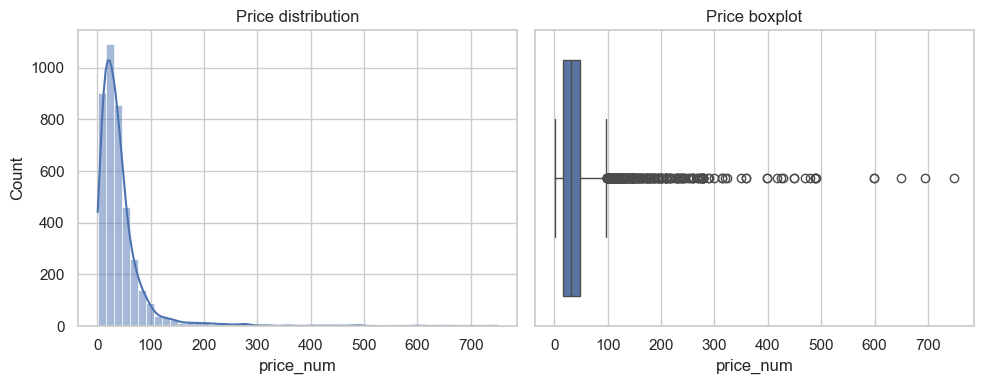

In [4]:
# Price distribution
if 'price' in df.columns:
    df['price_num'] = df['price'].astype(str).str.extract(r'(\d+\.?\d*)', expand=False)
    df['price_num'] = pd.to_numeric(df['price_num'], errors='coerce')
    price_vals = df['price_num'].dropna()
    # Only attempt plotting when plotting libs were imported successfully and plt is available
    if PLOTTING_AVAILABLE and plt is not None:
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1)
        sns.histplot(price_vals, bins=50, kde=True)
        plt.title('Price distribution')
        plt.subplot(1,2,2)
        sns.boxplot(x=price_vals)
        plt.title('Price boxplot')
        plt.tight_layout()
    else:
        print('matplotlib/seaborn not available — skipping price distribution plots')
else:
    print('price column not found')

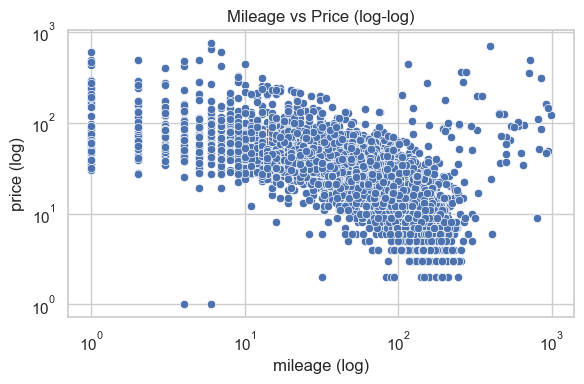

In [5]:
# Mileage vs Price scatter (if available)
# Accept several possible column names: 'mileage_km', 'mileage', and the common typo 'milage'
mcols = [c for c in ['mileage_km', 'mileage', 'milage'] if c in df.columns]
if mcols:
    mcol = mcols[0]
    df['mileage_num'] = df[mcol].astype(str).str.extract(r'(\d+\.?\d*)', expand=False)
    df['mileage_num'] = pd.to_numeric(df['mileage_num'], errors='coerce')
    # Only attempt plotting when plotting libs were imported successfully and plt is available
    if PLOTTING_AVAILABLE and plt is not None:
        plt.figure(figsize=(6,4))
        sns.scatterplot(data=df, x='mileage_num', y='price_num')
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel('mileage (log)')
        plt.ylabel('price (log)')
        plt.title('Mileage vs Price (log-log)')
        plt.tight_layout()
    else:
        print('matplotlib/seaborn not available — skipping mileage vs price plot')
else:
    print('mileage column not found')

Loaded pipeline from car_price_pipeline.joblib


,feature,importance
0,mileage_km,0.206854
1,brand_Lamborghini,0.125837
2,engine_cc,0.098087
3,brand_Rolls-Royce,0.074852
4,car_age,0.059409
5,model_Aventador SVJ Base,0.038228
6,brand_Ferrari,0.037542
7,model_Cullinan,0.034294
8,brand_Porsche,0.028845
9,brand_Bentley,0.019459


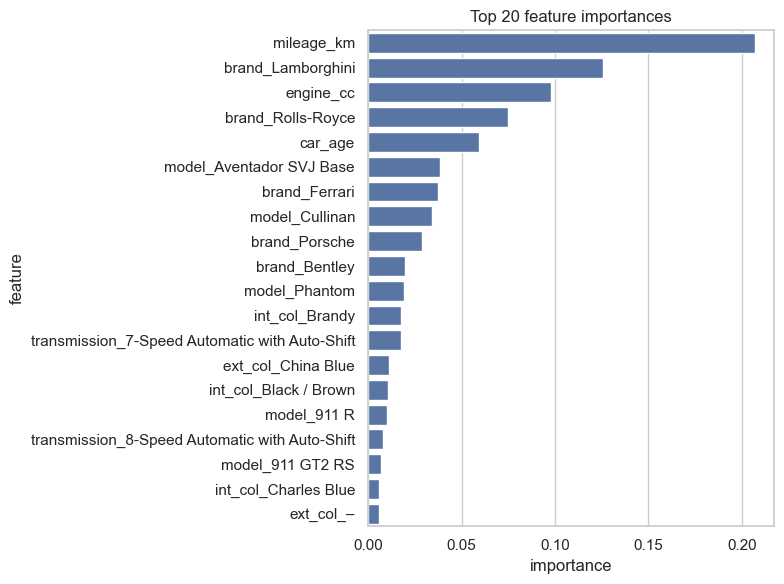

In [6]:
# Load trained pipeline and show feature importances (if available)
model_path = Path('car_price_pipeline.joblib')
if not model_path.exists():
    # try ML assignment path
    model_path = Path('ML assignment') / 'car_price_pipeline.joblib'
if not model_path.exists():
    print('Saved pipeline not found at', model_path)
else:
    pipeline = joblib.load(model_path)
    print('Loaded pipeline from', model_path)
    # Attempt to extract feature names from preprocessor
    try:
        pre = pipeline.named_steps['preprocessor']
        # numeric feature names
        num_cols = pre.transformers_[0][2]
        # categorical names from onehot encoder
        cat_info = pre.transformers_[1]
        cat_cols = cat_info[2]
        onehot = cat_info[1].named_steps['onehot']
        # Some OneHotEncoder versions expose get_feature_names_out, others get_feature_names
        if hasattr(onehot, 'get_feature_names_out'):
            cat_names = onehot.get_feature_names_out(cat_cols)
        else:
            cat_names = onehot.get_feature_names(cat_cols)
        feature_names = np.concatenate([num_cols, cat_names])
        importances = pipeline.named_steps['model'].feature_importances_
        fi = pd.DataFrame({'feature': feature_names, 'importance': importances})
        fi = fi.sort_values('importance', ascending=False).reset_index(drop=True)
        display(fi.head(30))
        if PLOTTING_AVAILABLE and plt is not None:
            plt.figure(figsize=(8,6))
            sns.barplot(data=fi.head(20), x='importance', y='feature')
            plt.title('Top 20 feature importances')
            plt.tight_layout()
        else:
            print('matplotlib/seaborn not available — skipping feature importance plot')
    except Exception as e:
        print('Could not extract feature importances:', e)

In [7]:
# Sample predictions using the loaded pipeline
if 'pipeline' in globals():
    # Choose a few sample rows (drop price if present)
    sample = df.sample(5, random_state=42).copy()
    actual = None
    if 'price_num' in sample.columns:
        actual = sample['price_num']
        sample = sample.drop(columns=['price_num'], errors='ignore')

    # Define same preprocessing as training/predict scripts so the pipeline gets expected columns
    def preprocess_df(df: pd.DataFrame) -> pd.DataFrame:
        # accept both spellings of mileage and the common typo 'milage'
        col_map_actual = {'model_year': 'year', 'milage': 'mileage_km', 'mileage': 'mileage_km', 'fuel_type': 'fuel'}
        df = df.rename(columns=col_map_actual)

        if 'price' in df.columns:
            df['price'] = df['price'].astype(str).str.extract(r'(\d+\.?\d*)', expand=False)
            df['price'] = pd.to_numeric(df['price'], errors='coerce')
            df = df.dropna(subset=['price'])

        if 'mileage_km' in df.columns:
            df['mileage_km'] = df['mileage_km'].astype(str).str.extract(r'(\d+\.?\d*)', expand=False)
            df['mileage_km'] = pd.to_numeric(df['mileage_km'], errors='coerce')

        if 'engine' in df.columns:
            df['engine_cc'] = df['engine'].astype(str).str.extract(r'(\d+\.?\d*)', expand=False)
            df['engine_cc'] = pd.to_numeric(df['engine_cc'], errors='coerce')
            df = df.drop(columns=['engine'], errors='ignore')

        if 'year' in df.columns:
            df['year'] = pd.to_numeric(df['year'], errors='coerce')
            df['car_age'] = pd.Timestamp.now().year - df['year']

        df = df.drop(columns=[c for c in ['name', 'year'] if c in df.columns], errors='ignore')
        return df

    X_sample = preprocess_df(sample.copy())

    try:
        preds = pipeline.predict(X_sample)
        out = sample.copy()
        out['predicted_price'] = preds
        if actual is not None:
            out['actual_price'] = actual.values
        display(out.head())
    except Exception as e:
        print('Prediction failed:', e)
else:
    print('Pipeline not loaded; cannot run sample predictions')

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,mileage_num,predicted_price,actual_price
2580,Lexus,IS 300 Base,2018,"50,992 mi.",Gasoline,260.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,A/T,White,Gray,At least 1 accident or damage reported,Yes,"$28,000",50,27.580000,28
3660,Chevrolet,Impala Base,2004,"64,500 mi.",Gasoline,180.0HP 3.4L V6 Cylinder Engine Gasoline Fuel,A/T,Beige,Beige,None reported,Yes,"$5,900",64,10.616667,5
897,RAM,2500 SLT,2017,"86,000 mi.",Diesel,350.0HP 6.7L Straight 6 Cylinder Engine Diesel...,6-Speed A/T,Gray,Gray,At least 1 accident or damage reported,Yes,"$41,000",86,40.246667,41
2091,Mercedes-Benz,SL-Class SL 550,2013,"24,933 mi.",Gasoline,429.0HP 4.6L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Silver,Red,At least 1 accident or damage reported,Yes,"$40,250",24,43.480000,40
1044,Ford,Shelby GT350R Base,2018,"18,500 mi.",Gasoline,526.0HP 5.2L 8 Cylinder Engine Gasoline Fuel,M/T,Blue,Black,At least 1 accident or damage reported,Yes,"$77,999",18,63.836667,77


## Conclusion
The RandomForest pipeline is the best performing model from our experiments and is saved as a joblib pipeline for reproducible inference. For a school submission, include this notebook, the `train_final.py` and `predict_final.py` scripts, the saved pipeline, and the brief report `REPORT_FINAL.md`.

Next steps: feature engineering (brand/model extraction), target encoding for high-cardinality fields, and trying LightGBM/XGBoost for potential further gains.